# 예제 1

Cora Dataset : 2708개의 논문들이 서로 어떤 관계로 cited 되었고, 어떤 단어가 포함되었는지에 관한 데이터셋

content file : 논문 id / 논문 feature 정보(1443개단어) / 논문 장르

cited file : 참조된 논문 -> 참조한 논문 ( 개별 edge 정보만 담고 있기 때문에 매트릭스로 가공해야 한다. )

https://github.com/tkipf/pygcn

https://chioni.github.io/posts/gnn/

In [2]:
import numpy as np
import scipy.sparse as sp
import torch

In [3]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

In [4]:
def load_data(path="./data/cora/", dataset="cora"):
    
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset), dtype=np.dtype(str)) # np.genfromtxt : 텍스트 파일 읽기
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) # 희소행렬
    labels = encode_onehot(idx_features_labels[:, -1]) # 원핫인코딩

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), # sp.coo_matrix : 매트릭스의 인덱스로 압축하여 저장
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [5]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [6]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [7]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [8]:
A, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


In [9]:
print(A)
print(A.layout) # s[parse_coo]

print('============ features =======')
print(features)

print('============ labels =================')
print(labels)
print(labels.unique()) # 7개의 label


print('============ labels =================')
print(idx_train)  # 0-199  # 200개
print(idx_val)    # 200-499 # 300개
print(idx_test)   # 500-1499 # 1000개

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)
torch.sparse_coo
============ features =======
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
============ labels =================
tensor([4, 6, 5,  ..., 0, 2, 4])
tensor([0, 1, 2, 3, 4, 5, 6])
============ labels =================
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  5

In [10]:
import torch.nn as nn
class GCN_layer(nn.Module) :
    def __init__(self, in_features, out_features, A) :
        super(GCN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.A = A
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, X) :
        return self.fc(torch.spmm(self.A, X)) # 이웃 정보를 종합한다.


class GCN(nn.Module) :
    def __init__(self, num_feature, num_class, A) :
        super(GCN, self).__init__()
        self.feature_extractor = nn.Sequential( GCN_layer(num_feature, 16, A),
                                               nn.ReLU(),
                                               GCN_layer(16, num_class, A))
    
    def forward(self, X) :
        return self.feature_extractor(X)

In [11]:
def train(model, Loss, optimizer, num_epochs) :
    train_loss_arr = []
    test_loss_arr = []

    best_test_loss = 99999999
    early_stop, early_stop_max = 0., 10.

    for epoch in range(num_epochs) :

        # forward pass
        model.train()
        output = model(features)
        train_loss = criterion(output[idx_train], labels[idx_train])

        # backward, optimize
        train_loss.backward()
        optimizer.step()

        train_loss_arr.append(train_loss.data)

        if epoch % 10 == 0 :
            model.eval()

            output = model(features)
            val_loss = criterion(output[idx_val], labels[idx_val])
            test_loss = criterion(output[idx_test], labels[idx_test])

            val_acc = accuracy(output[idx_val], labels[idx_val])
            test_acc = accuracy(output[idx_test], labels[idx_test])

            test_loss_arr.append(test_loss)

            best_ACC = val_acc
            final_ACC = test_acc

            if best_ACC < val_acc :
                best_ACC = val_acc
                early_stop = 0
                final_ACC = test_acc
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test ACC: {:.4f} *'.format(epoch, 100, train_loss.data, test_loss, test_acc))

            else :
                early_stop += 1
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test ACC: {:.4f} *'.format(epoch, 100, train_loss.data, test_loss, test_acc))

        if early_stop >= early_stop_max :
            break

        print('Final Accuracy : ', final_ACC)

In [12]:
# 비교해보기 위한 Fully Connected Neural Network
class FCN(nn.Module) :
    def __init__(self, num_features, num_class) :
        super(FCN, self).__init__()

        self.feature_extractor = nn.Sequential(
                                                nn.Linear(num_features, 16),
                                                nn.ReLU(),
                                                nn.Linear(16, num_class)
                                            )

    def forward(self, x) :
        return self.feature_extractor(x)

In [13]:
import torch.optim as optim

In [14]:
# FCN 학습 후 epoch에 따른 loss 확인
model = FCN(features.size(1), labels.unique().size(0))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)
train(model, criterion, optimizer, 1000)

Epoch [0/100], Train Loss: 1.9629, Test Loss: 1.9444, Test ACC: 0.1380 *
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Final Accuracy :  tensor(0.1380, dtype=torch.float64)
Epoch [10/100], Train Loss: 1.1886, Test Loss: 2.0284, Test ACC: 0.2220 *
Final Accuracy :  tensor(0.2220, dtype=torch.float64)
Final Accuracy :  tensor(0.2220, dtype=torch.float64)
Final Accuracy :  tensor(0.2220, dtype=torch.float64)
Final Accuracy :  tensor(0.2220, dtype=torch.float64)
Final Accuracy :  tensor(0.2220, dtype=torch.float64)
Final Accuracy :  tensor(0.2220, dtype=torc

In [15]:
# GCN 학습 후 epoch에 따른 loss 확인
model = GCN(features.size(1), labels.unique().size(0), A)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)
train(model, criterion, optimizer, 1000)

Epoch [0/100], Train Loss: 2.0312, Test Loss: 1.9524, Test ACC: 0.0720 *
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Final Accuracy :  tensor(0.0720, dtype=torch.float64)
Epoch [10/100], Train Loss: 1.5264, Test Loss: 1.8417, Test ACC: 0.2540 *
Final Accuracy :  tensor(0.2540, dtype=torch.float64)
Final Accuracy :  tensor(0.2540, dtype=torch.float64)
Final Accuracy :  tensor(0.2540, dtype=torch.float64)
Final Accuracy :  tensor(0.2540, dtype=torch.float64)
Final Accuracy :  tensor(0.2540, dtype=torch.float64)
Final Accuracy :  tensor(0.2540, dtype=torc

# 예제2

In [37]:
class GCN_layer(nn.Module):
    
    def __init__(self, in_features, out_features, A):
        super(GCN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.A = A
        self.fc = nn.Linear(in_features, out_features)
        
    def forward(self, X):
        return self.fc(torch.spmm(self.A, X))
    
# 이전에 GCN 네트워크를 Pytorch로 구현할 때
# 그래프 구조의 데이터를 취합하기 위하여 adjency matrix A를 생성했다.
# DGL이 있다면 이것을 아래와 같이 대체할 수 있다고 한다.

import dgl.function as fn
import dgl

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

dgl.DGLGraph.update_all(gcn_msg, gcn_reduce)

NameError: name 'self' is not defined

In [39]:
import time
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from dgl import DGLGraph
import dgl

from dgl.data import CitationGraphDataset
citeseer = CitationGraphDataset('citeseer')

Extracting file to C:\Users\won\.dgl\citeseer


C:\Users\won\anaconda3\envs\cpu_env\lib\site-packages\dgl\data\citation_graph.py:258: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


C:\Users\won\anaconda3\envs\cpu_env\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset.g instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


None

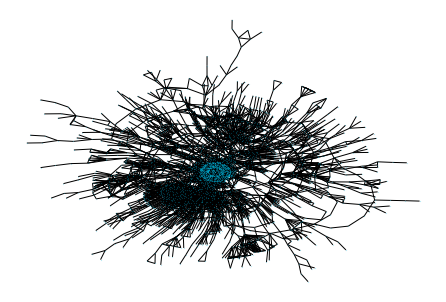

In [40]:
dir(citeseer)

# networkx 라이브러리의 오브젝트인 그래프가 citeseer.graph 로 들어가 있다.
# draw 함수를 통해 아래와 같은 끔찍한 이미지를 만들어 낼 수 있다.
import networkx as nx

nx_G = citeseer.graph.to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
display(nx.draw(nx_G, pos, with_labels=False, node_size = 0.01, node_color='#00b4d9'))

In [41]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        
        # Expression 3
        # F-Dimension의 피쳐 스페이스가 single fc-layer 지나며 F'-Dimension으로 임베딩 
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # i노드의 F' + j노드의 F' 길이의 벡터를 합쳐서 Attention Coefficient를 리턴 	
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

        
        
    # Expression 3에서 어텐션으로 넘어온 값을 Leaky Relu 적용하는 Layer
	# src는 source vertex, dst는 destination vertex의 약자	
    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    
    # dgl에서는 모든 노드에 함수를 병렬 적용 할 수 있는 update_all 이라는 api를 제공한다.
    # 해당 api 사용을 위해 텐서를 흘려보내는 역할을 한다고 한다.
	# 구체적인 update_all의 알고리즘은 잘 모르겠으니 그냥 input 함수라고 생각하자.
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}


    # update_all에서는 흘려보내진 텐서를 각 노드의 mailbox라는 오브젝트에 저장하나 보다.
    # 각 노드에는 여러 이웃이 있으니 mailbox에는 여러개의 attention coefficient가 있다.
    # Expression 4에서 softmax 계수를 가중하여 element wise하게 합한다.  
    def reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    
    # (1) fc layer를 통해 피쳐를 임베딩
    # (2) 그레프에 임베딩 된 벡터를 저장
    # (3) apply_edges api를 모든 엣지에 적용하여 i - j 간의 attention coefficeint를 계산
    # (4) 그래프에 저장된 z와e를 텐서로 reduce_func에 전달하여 새로운 h' 를 얻는다.
    def forward(self, h):
        z = self.fc(h)
        self.g.ndata['z'] = z
        self.g.apply_edges(self.edge_attention)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [42]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [43]:
class GAT(nn.Module):
    
    # 두 Layer의 인풋과 아웃풋이 다른 것을 볼 수 있다
    # 원래 노드의 feature 개수가 F개라고 했을 때, layer를 한 번 지나며 F'개로 임베딩했다.
    # 이것을 num_heads(attention 개수) 만큼 multi-head하게 보아 K*F' 길이로 cat했다.
    # 두 번째 layer에서는 K를 1로 설정하여 single-head attention을 적용했다.  
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [44]:
def load_citeseer_data():
    data = citeseer
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = data.graph
    
    # add self loop
    # GAT는 i <-> i의 self-attention도 종합하기 때문에 해당 정보를 edge에 추가해준다
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

In [47]:
g, features, labels, mask = load_citeseer_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=6,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(1000):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)
        
    if epoch % 100 == 0:
        print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(epoch, loss.item(), np.mean(dur)))
         

Epoch 00000 | Loss 1.7918 | Time(s) nan
Epoch 00100 | Loss 1.6321 | Time(s) 0.1197
Epoch 00200 | Loss 1.2755 | Time(s) 0.1198
Epoch 00300 | Loss 0.8526 | Time(s) 0.1199
Epoch 00400 | Loss 0.5026 | Time(s) 0.1195
Epoch 00500 | Loss 0.2971 | Time(s) 0.1193
Epoch 00600 | Loss 0.1837 | Time(s) 0.1203
Epoch 00700 | Loss 0.1175 | Time(s) 0.1207
Epoch 00800 | Loss 0.0790 | Time(s) 0.1204
Epoch 00900 | Loss 0.0556 | Time(s) 0.1203


In [48]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr)
display(plt.show())

NameError: name 'train_loss_arr' is not defined

In [49]:
mask = torch.BoolTensor(data.test_mask)

pred = np.argmax(logp[mask].detach().numpy(), axis = 1)
answ = labels[mask].numpy()
np.sum([1 if pred[i] == answ[i] else 0 for i in range(len(pred))]) / len(pred) * 100

NameError: name 'data' is not defined